In [51]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [52]:
#Get the stock quote 
df = web.DataReader('GOOGL', data_source='yahoo', start='2019-01-01', end='2021-01-12') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,1060.790039,1025.280029,1027.199951,1054.680054,1593400,1054.680054
2019-01-03,1066.260010,1022.369995,1050.670044,1025.469971,2098000,1025.469971
2019-01-04,1080.000000,1036.859985,1042.560059,1078.069946,2301100,1078.069946
2019-01-07,1082.699951,1062.640015,1080.969971,1075.920044,2372300,1075.920044
2019-01-08,1093.349976,1068.349976,1086.000000,1085.369995,1770700,1085.369995
...,...,...,...,...,...,...
2021-01-06,1743.969971,1696.099976,1700.260010,1722.880005,2329400,1722.880005
2021-01-07,1777.819946,1726.760010,1726.760010,1774.339966,2096800,1774.339966
2021-01-08,1799.359985,1761.219971,1777.160034,1797.829956,1773400,1797.829956


In [53]:
df.shape

(512, 6)

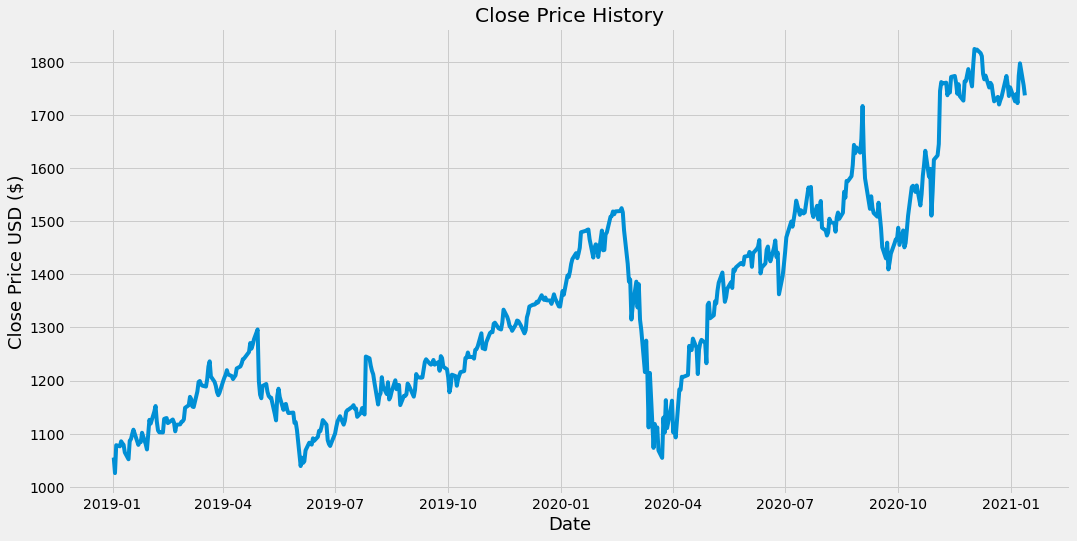

In [54]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [55]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get/Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [56]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [57]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [58]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [59]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [60]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [61]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [62]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

350/350 [==============================] - 4s 12ms/step - loss: 0.0055


In [63]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [64]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [65]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [66]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [67]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

70.72580626199807

<ipython-input-68-c1beac80e8e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


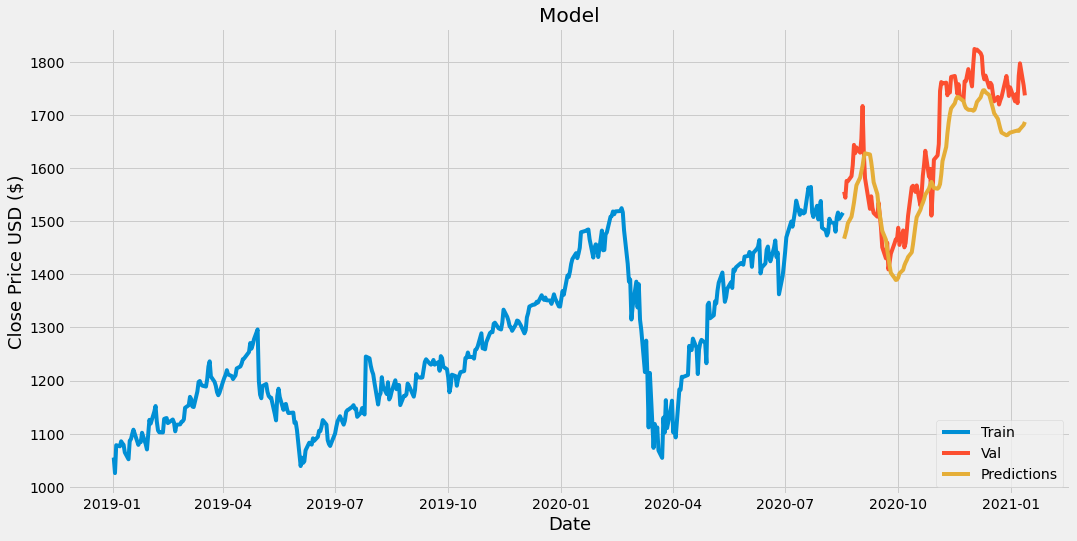

In [68]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [69]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-08-18,1555.780029,1467.286865
2020-08-19,1544.609985,1475.473633
2020-08-20,1576.250000,1484.428223
2020-08-21,1575.569946,1496.277954
2020-08-24,1585.150024,1508.760986
...,...,...
2021-01-06,1722.880005,1671.311035
2021-01-07,1774.339966,1670.382324
2021-01-08,1797.829956,1673.756226


In [72]:
#Get the quote
goog_quote = web.DataReader('GOOGL', data_source='yahoo', start='2019-01-01', end='2021-01-12')
#Create a new dataframe
new_df = goog_quote.filter(['Close'])
#Get the last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[1689.7123]]


In [73]:
#Get the quote
goog_quote2 = web.DataReader('GOOGL', data_source='yahoo', start='2021-01-12', end='2021-01-12')
print(goog_quote2['Close'])

Date
2021-01-12    1737.430054
Name: Close, dtype: float64
